# Plots tutorial
### Vega has a module called "Wedge" that can compute wedges for you. This is a short tutorial on how to use it to plot correlation functions from vega

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vega import VegaInterface, Wedge
from astropy.io import fits

# Function that plots the wedges
### Hopefully this will also be added to Vega in the future
### If you want different mu bins, just change the mus array in this function

In [2]:
def plot_wedges(models, covariance, multi_model=False, labels=None, data=None, cross=False):
    """Compute and plot wedges from vega model

    Parameters
    ----------
    models : np.array or list
        If multi_model is True, this is a list of correlation function models
        If multi_model is False, this is just a single model
    covariance : np.array
        The covariance matrix
    multi_model : bool, optional
        Whether there is only one or multiple models
    labels : list[string], optional
        List of labels for each model
    data : dict, optional
        Data vector
    cross : bool, optional
        Whether the input model/data are cross-correlations
    """
    plt.rcParams['font.size'] = 14
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    axs = np.array(axs).reshape(-1)
    mus = np.array([0., 0.5, 0.8, 0.95, 1.])
    mu_zip = zip(mus[:-1],mus[1:])

    for i, mu in enumerate(mu_zip):
        if not cross:
            wedge_obj = Wedge(mu=mu, rp=(0., 200., 50), rt=(0., 200., 50), r=(0., 200., 50), abs_mu=True)
        else:
            wedge_obj = Wedge(mu=mu, rp=(-200., 200., 100), rt=(0., 200., 50), r=(0., 200., 50), abs_mu=True)
        
        if data is not None:
            rd, dd, cd = wedge_obj(data, covariance=covariance)
            axs[i].errorbar(rd, dd * rd**2, yerr=np.sqrt(cd.diagonal()) * rd**2, fmt="o")
        
        if multi_model:
            for model, label in zip(models, labels):
                r, d, _ = wedge_obj(model, covariance=covariance)
                axs[i].plot(r, d * r**2, '-', label=label)
        else:
            r, d, _ = wedge_obj(models, covariance=covariance)
            axs[i].plot(r, d * r**2, '-', label='Model')
        
        axs[i].set_ylabel(r"$r^2\xi(r)$")
        axs[i].set_xlabel(r"$r~[\mathrm{Mpc/h}]$")
        axs[i].set_title(r"${}<\mu<{}$".format(mu[0], mu[1]), fontsize=16)
        axs[i].set_xlim(0, 180)
        axs[i].legend()
        axs[i].grid()

# Initialize vega and run the fitter
### Here I'm using the DR16 Lya(Lya)xLya(Lya) and fitting a simple kaiser model with no contaminants

In [3]:
vega = VegaInterface("D:/work/run/rundr16/main_auto.ini")

INFO: reading input Pk d:\work\repo\dev\vega\vega\models\PlanckDR16\PlanckDR16.fits


In [4]:
vega.minimize()

LOG: Full matrix is positive definite
LOG: Reduced matrix is positive definite
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2352                       │        Ncalls = 20 (20 total)        │
│ EDM = 6.71e-07 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Mino

# Compute besfit model 

In [5]:
model = vega.compute_model(vega.bestfit.values)

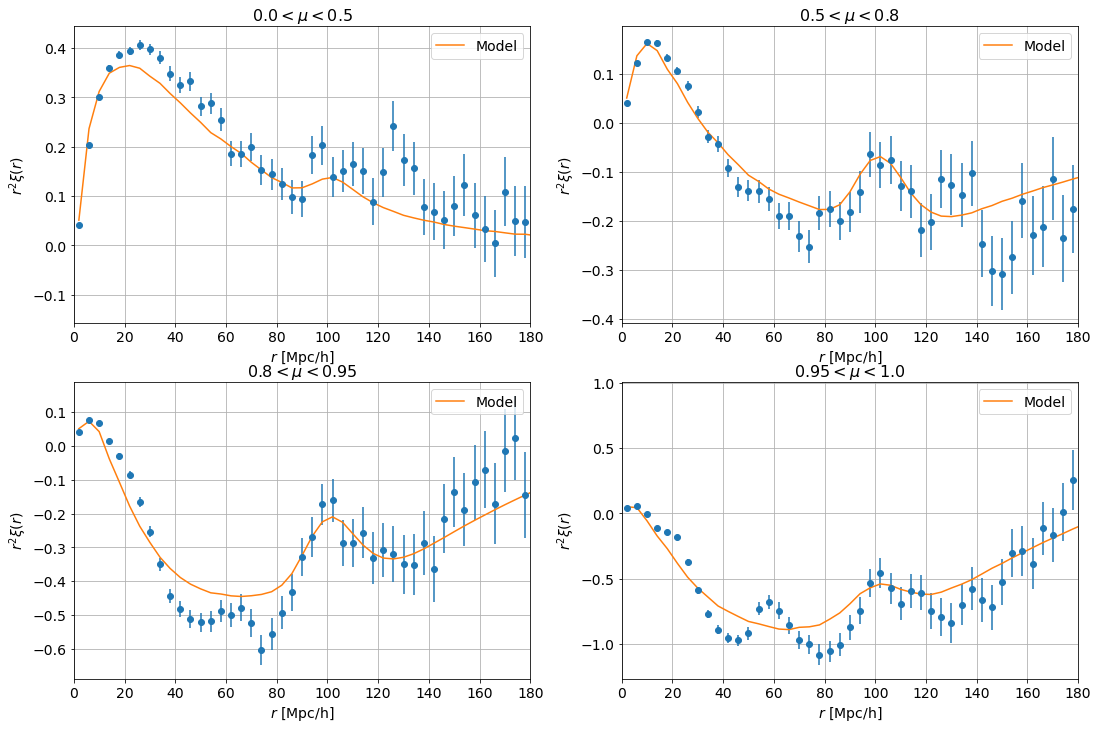

In [6]:
plot_wedges(model['lyaxlya'], vega.data['lyaxlya'].cov_mat, data=vega.data['lyaxlya'].data_vec)

# Alternatively, if you ran Vega in console, you can read the bestfit model from the output file

In [7]:
hdul = fits.open("D:/work/run/rundr16/output/dr16_lyalya_lyalya_example.fits")

In [8]:
hdul.info()

Filename: D:/work/run/rundr16/output/dr16_lyalya_lyalya_example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  MODEL         1 BinTableHDU     27   2500R x 1C   [D]   
  2  BESTFIT       1 BinTableHDU     33   4R x 4C   [12A, D, D, 4D]   
  3  PK_LYAXLYA    1 BinTableHDU     13   1000R x 2C   [814D, 814D]   
  4  XI_LYAXLYA    1 BinTableHDU     17   2500R x 4C   [D, D, D, D]   


In [9]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                 2500 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'lyaxlya '                                                            
TFORM1  = 'D       '                                                            
EXTNAME = 'MODEL   '           / extension name                                 
HIERARCH par binsize lyaxlya = 4.0                                              
HIERARCH per binsize lyaxlya

In [10]:
model_from_file = hdul[1].data['lyaxlya']
hdul.close()

# Plot the two models together (they are the same)

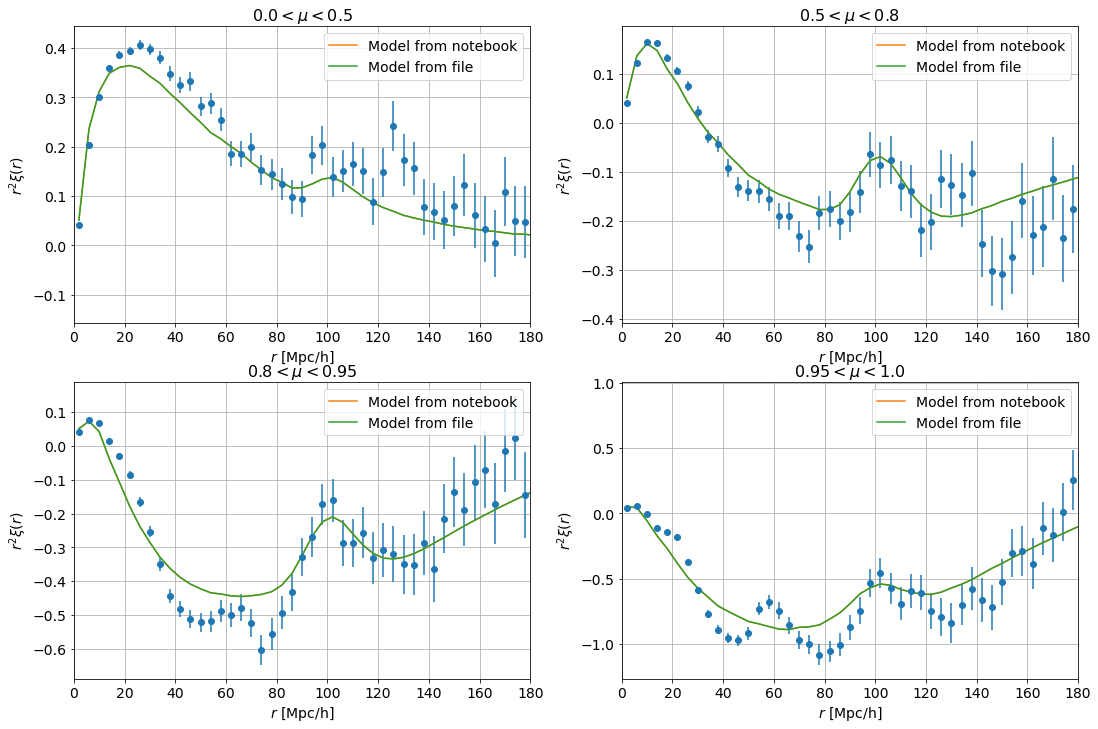

In [11]:
plot_wedges([model['lyaxlya'], model_from_file], vega.data['lyaxlya'].cov_mat, multi_model=True, labels=['Model from notebook', 'Model from file'], data=vega.data['lyaxlya'].data_vec)

# Compute and plot a slightly different model

In [12]:
pars = vega.bestfit.values.copy()

In [13]:
pars

{'ap': 1.0280208595668199,
 'at': 1.0025073141934435,
 'bias_eta_LYA': -0.19563344010293804,
 'beta_LYA': 1.2072549176443526}

In [14]:
pars['ap'] = 0.95
new_model = vega.compute_model(pars)

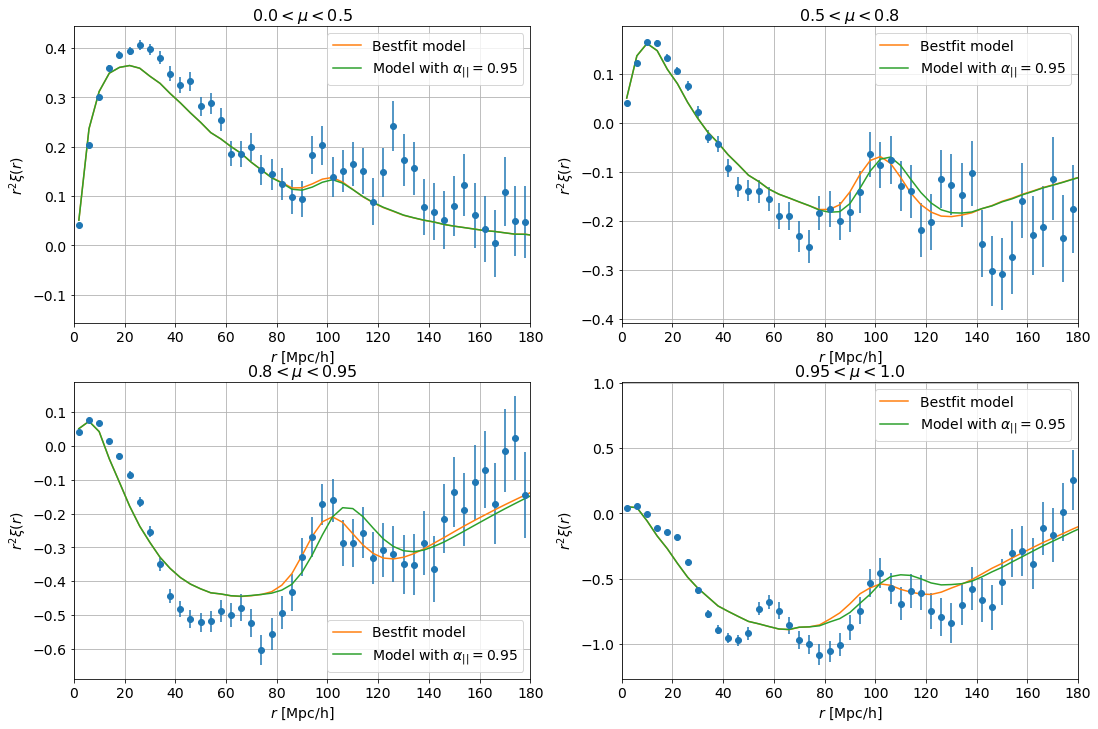

In [15]:
plot_wedges([model['lyaxlya'], new_model['lyaxlya']], vega.data['lyaxlya'].cov_mat, multi_model=True, labels=['Bestfit model', r'Model with $\alpha_{||}=0.95$'], data=vega.data['lyaxlya'].data_vec)